In [2]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import style
style.use('ggplot')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller 
from arch.unitroot import ADF
from statsmodels.stats.diagnostic import acorr_ljungbox 
from statsmodels.graphics.api import qqplot
import time
import datetime
pd.set_option('display.float_format', lambda x: '%.5f' % x) 
np.set_printoptions(precision=5, suppress=True) 
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Heiti TC']

In [40]:
#read data
file_path = '/Users/gali/Desktop/dsmp-2024-group15/Python files/LSTM/SARIMAX_asks.csv'
ask = pd.read_csv(file_path)
print(ask)
#ask = ask[:800]
ask['adjusted_time_hours'] = pd.to_timedelta(ask['adjusted_time_hours'], unit='h')
start_date = pd.to_datetime('2025-01-01')
ask['datetime'] = start_date + ask['adjusted_time_hours']
ask.set_index('datetime', inplace=True)
ask = ask.drop('adjusted_time_hours',axis = 1)
ask = ask.drop('Type',axis = 1)
print(ask)
print(type(ask.index))

     Type  adjusted_time_hours     Price
0     ask              0.00000 259.05878
1     ask              1.00000 257.92273
2     ask              2.00000 266.82759
3     ask              3.00000 280.17647
4     ask              4.00000 283.92644
...   ...                  ...       ...
1058  ask           1058.00000 115.22624
1059  ask           1059.00000 115.32450
1060  ask           1060.00000 113.81467
1061  ask           1061.00000 114.35305
1062  ask           1062.00000 114.18095

[1063 rows x 3 columns]
                        Price
datetime                     
2025-01-01 00:00:00 259.05878
2025-01-01 01:00:00 257.92273
2025-01-01 02:00:00 266.82759
2025-01-01 03:00:00 280.17647
2025-01-01 04:00:00 283.92644
...                       ...
2025-02-14 02:00:00 115.22624
2025-02-14 03:00:00 115.32450
2025-02-14 04:00:00 113.81467
2025-02-14 05:00:00 114.35305
2025-02-14 06:00:00 114.18095

[1063 rows x 1 columns]
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [33]:
skewness = ask['Price'].skew()
print("偏度: ", skewness)

偏度:  0.13996953675706805


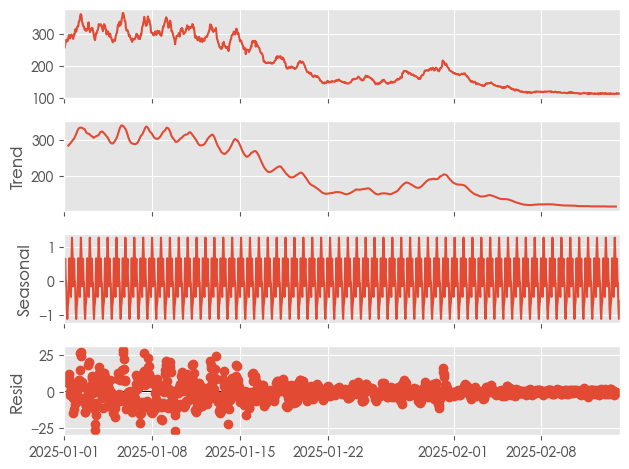

In [43]:
decomposition = sm.tsa.seasonal_decompose(ask, model='additive', period=17)  # period取决于数据的季节性周期
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# 可视化分解结果
decomposition.plot()
plt.savefig('sea.png')
plt.show()

Testing original data:
ADF Statistic: -1.161111
p-value: 0.690097
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
datetime
2025-01-01 01:00:00   -1.13605
2025-01-01 02:00:00    8.90485
2025-01-01 03:00:00   13.34888
2025-01-01 04:00:00    3.74997
2025-01-01 05:00:00   -5.43469
                        ...   
2025-02-03 03:00:00   -0.10180
2025-02-03 04:00:00   -1.05286
2025-02-03 05:00:00   -0.60826
2025-02-03 06:00:00   -1.33482
2025-02-03 07:00:00    2.15114
Name: Price, Length: 799, dtype: float64

Determining the differencing order needed for stationarity:
datetime
2025-01-01 01:00:00   -1.13605
2025-01-01 02:00:00    8.90485
2025-01-01 03:00:00   13.34888
2025-01-01 04:00:00    3.74997
2025-01-01 05:00:00   -5.43469
                        ...   
2025-02-03 03:00:00   -0.10180
2025-02-03 04:00:00   -1.05286
2025-02-03 05:00:00   -0.60826
2025-02-03 06:00:00   -1.33482
2025-02-03 07:00:00    2.15114
Name: Price, Length: 799, dtype: float64

Differencing Order: 1
ADF Statistic:

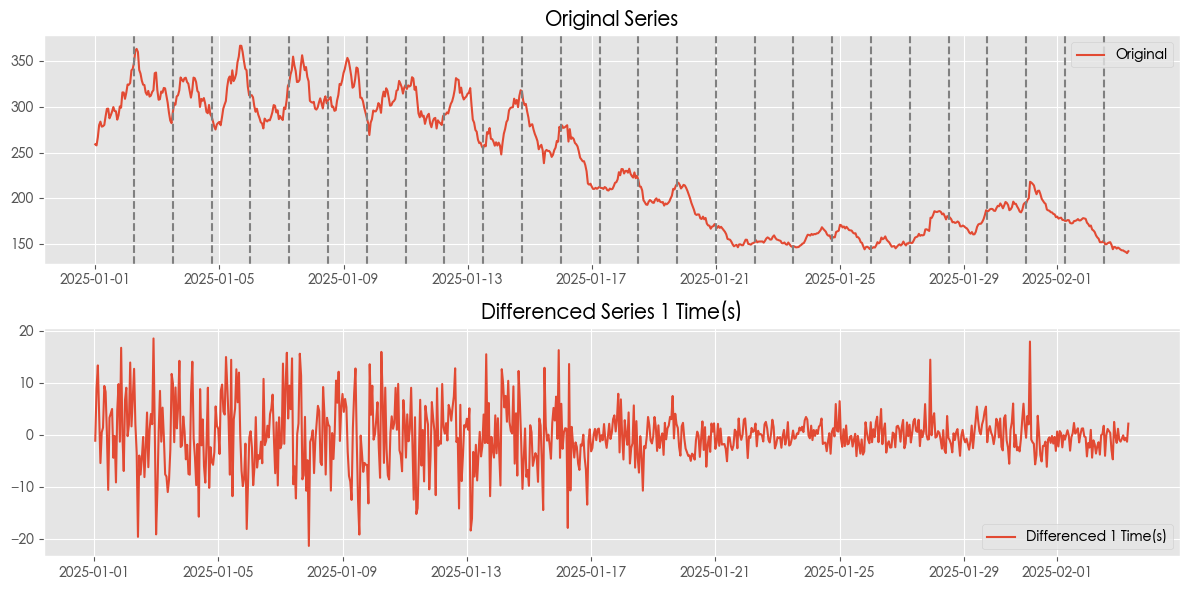

In [34]:
def adf_test(time_series):
    """Perform ADF test and return results"""
    result = adfuller(time_series, autolag='AIC')  # ADF test
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result

def determine_diff_order(timeseries, max_diff=5):
    """Apply iterative differencing and ADF test to determine the order of differencing"""
    p_value = 1
    diff_order = 1
    while p_value > 0.05 and diff_order <= max_diff:
        diff_series = timeseries.diff(periods=diff_order).dropna()
        print(diff_series)
        print(f"\nDifferencing Order: {diff_order}")
        result = adf_test(diff_series)
        p_value = result[1]
        if p_value < 0.05:
            print("Series is stationary")
            break
        diff_order += 1
    return diff_order

# Check original data's stationarity
print("Testing original data:")
adf_test(ask.Price)
ask_diff = ask.Price.diff().dropna()
print(ask_diff)

# Determine the order of differencing needed
print("\nDetermining the differencing order needed for stationarity:")
order = determine_diff_order(ask.Price)

# Plot original and differenced data
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(ask.Price, label='Original')
plt.title('Original Series')
data_points = len(ask.Price)
plt.legend()
interval_hours = 30
start_date = ask.index[0]
end_date = ask.index[-1]
num_intervals = int(((end_date - start_date).total_seconds() / 3600) // interval_hours)
for i in range(1, num_intervals + 1):
    plt.axvline(x=start_date + pd.Timedelta(hours=interval_hours * i), color='gray', linestyle='--')


plt.subplot(212)
plt.plot(ask.Price.diff(periods=order).dropna(), label=f'Differenced {order} Time(s)')
plt.title(f'Differenced Series {order} Time(s)')
plt.legend()

plt.tight_layout()
plt.show()


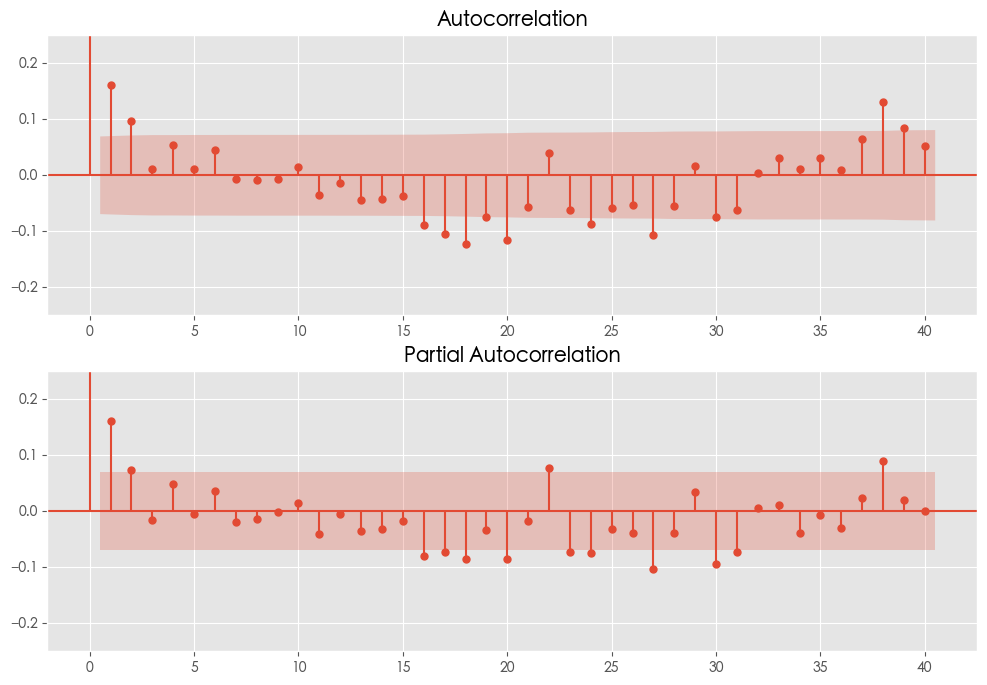

In [35]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ask_diff,lags=40,ax=ax1)
plt.ylim(-0.25, 0.25)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ask_diff,lags=40,ax=ax2)
plt.ylim(-0.25, 0.25)
plt.savefig('acfpacf.png')

In [36]:
import itertools
p = d = q = range(0, 2)  
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None

for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(ask,
                                        order=param)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            
    except:
        continue

print("Best SARIMAX model parameters - AIC:", best_aic)
print("p,d,q:", best_pdq)

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.91816D+00    |proj g|=  2.66454D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.665D-10   6.918D+00
  F =   6.9181619413190649     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.9

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Forecast Mean: 2025-02-03 08:00:00   142.17429
2025-02-03 09:00:00   142.29251
2025-02-03 10:00:00   142.35637
2025-02-03 11:00:00   142.39086
2025-02-03 12:00:00   142.40949
                         ...   
2025-02-08 23:00:00   142.43137
2025-02-09 00:00:00   142.43137
2025-02-09 01:00:00   142.43137
2025-02-09 02:00:00   142.43137
2025-02-09 03:00:00   142.43137
Freq: H, Name: predicted_mean, Length: 140, dtype: float64
Empty DataFrame
Columns: [Forecast]
Index: []


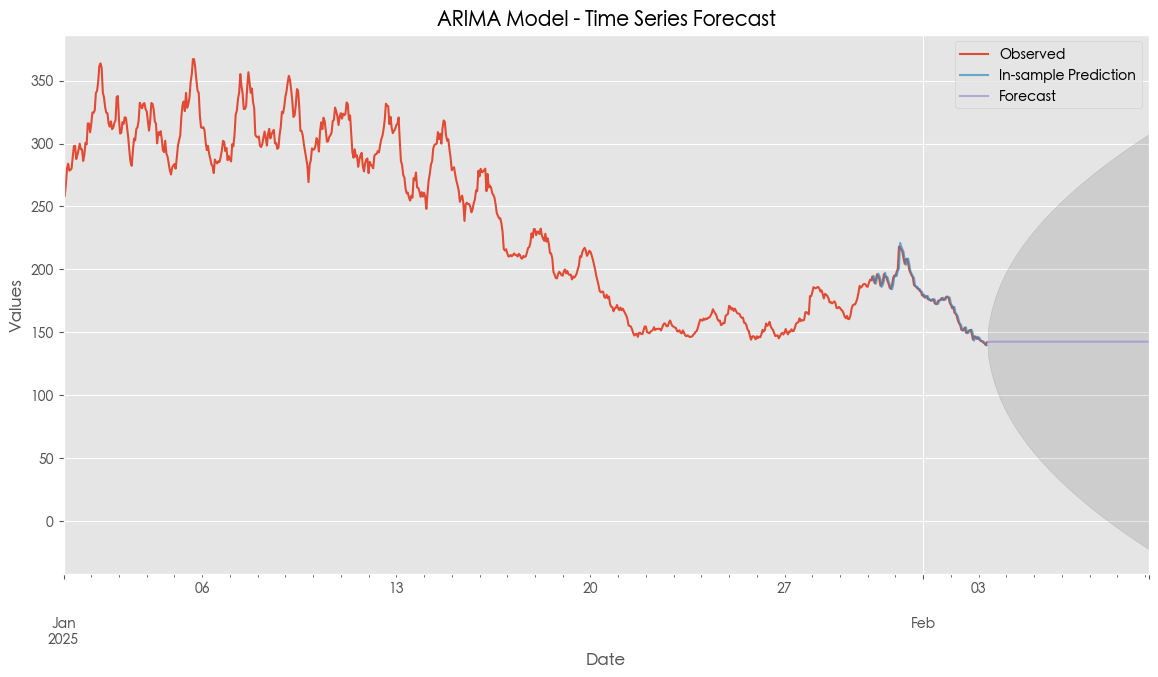

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  800
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2478.154
Date:                Tue, 30 Apr 2024   AIC                           4962.309
Time:                        11:58:03   BIC                           4976.359
Sample:                    01-01-2025   HQIC                          4967.707
                         - 02-03-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5401      0.119      4.545      0.000       0.307       0.773
ma.L1         -0.3902      0.128     -3.043      0.002      -0.642      -0.139
sigma2        28.9403      1.026     28.206      0.0

In [39]:
results = sm.tsa.ARIMA(ask.Price, order = (1,1,1)).fit()
prediction = results.get_prediction(start=700, dynamic=False)
predicted_mean = prediction.predicted_mean
forecast = results.get_forecast(steps=140)
forecast_mean = forecast.predicted_mean
print("Forecast Mean:", forecast_mean)

# 检查预测值是否包含数据
if forecast_mean.empty:
    print("预测结果为空。可能的原因包括索引不匹配或模型拟合问题。")
else:
    df_forecast = pd.DataFrame(forecast_mean, columns=['Forecast'])
    print(df_forecast)
start_date = '2025-02-01 00:00:00'
# Plot the results
plt.figure(figsize=(14, 7))
#.loc[start_date:]
ask['Price'].plot(label='Observed')
predicted_mean.plot(label='In-sample Prediction', alpha=0.7)
forecast_mean.plot(label='Forecast', alpha=0.7)
plt.fill_between(forecast_mean.loc[start_date:].index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='k', alpha=0.1)
plt.title('ARIMA Model - Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
#plt.ylim(100, 180)
plt.show()
print(results.summary())

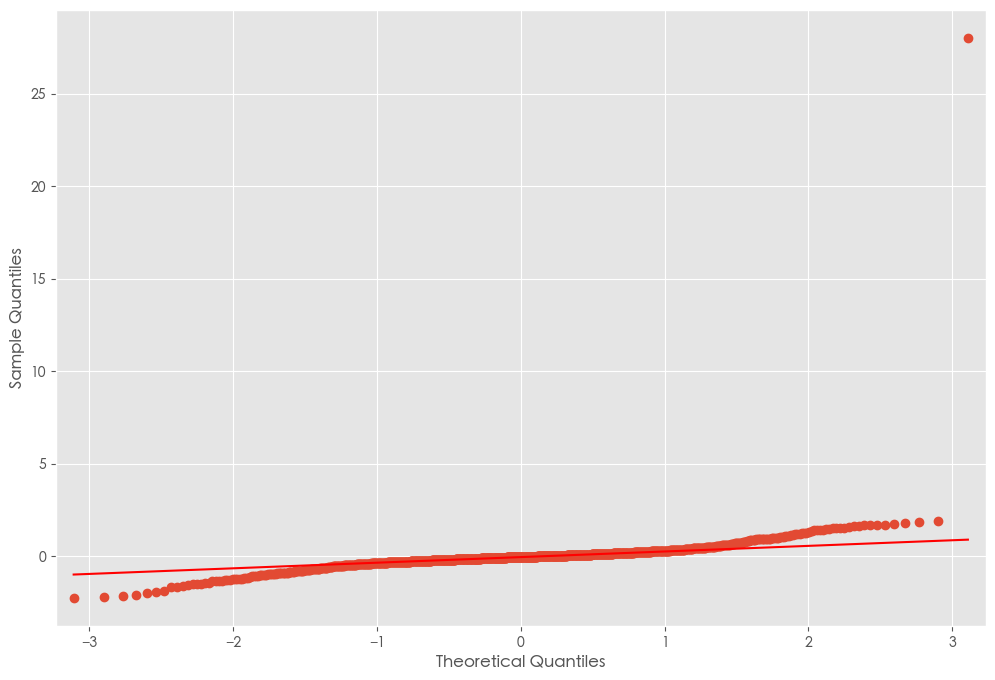

In [14]:
from statsmodels.graphics.api import qqplot
#model evaluation using residual, this is not an ideal outcome
resid = results.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)